## <small>
Copyright (c) 2017-21 Andrew Glassner

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.
</small>



# Deep Learning: A Visual Approach
## by Andrew Glassner, https://glassner.com
### Order: https://nostarch.com/deep-learning-visual-approach
### GitHub: https://github.com/blueberrymusic
------

### What's in this notebook

This notebook is provided to help you work with Keras and TensorFlow. It accompanies the bonus chapters for my book. The code is in Python3, using the versions of libraries as of April 2021.

Note that I've included the output cells in this saved notebook, but Jupyter doesn't save the variables or data that were used to generate them. To recreate any cell's output, evaluate all the cells from the start up to that cell. A convenient way to experiment is to first choose "Restart & Run All" from the Kernel menu, so that everything's been defined and is up to date. Then you can experiment using the variables, data, functions, and other stuff defined in this notebook.


# Bonus Chapter 3 - Notebook 1: Improving the model

In [1]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dropout
from tensorflow.keras.constraints import MaxNorm
import h5py
import numpy as np

from tensorflow.keras import backend as keras_backend
keras_backend.set_image_data_format('channels_last')

In [2]:
# Workaround for Keras issues on Mac computers (you can comment this
# out if you're not on a Mac, or not having problems)
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [3]:
# Make a File_Helper for saving and loading files.

save_files = False

import os, sys, inspect
current_dir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
sys.path.insert(0, os.path.dirname(current_dir)) # path to parent dir
from DLBasics_Utilities import File_Helper
file_helper = File_Helper(save_files)

Using TensorFlow backend.


In [4]:
# Load and process the MNIST data

random_seed = 42

# load the MNIST data
(X_train, y_train), (X_test, y_test) = mnist.load_data()
image_height = X_train.shape[1]
image_width = X_train.shape[2]
number_of_pixels = image_height * image_width

# cast the sample data to the current Keras floating-point type
X_train = keras_backend.cast_to_floatx(X_train)
X_test = keras_backend.cast_to_floatx(X_test)

# scale data to range [0, 1]
X_train /= 255.0
X_test /= 255.0

# save labels in their non-one-hot form
original_y_train = np.copy(y_train)
original_y_test = np.copy(y_test)

# replace label data with one-hot encoded versions
number_of_classes = 1 + max(np.append(y_train, y_test))
y_train = to_categorical(y_train, number_of_classes)
y_test = to_categorical(y_test, number_of_classes)

# reshape to 2D grid, one line per image
X_train = X_train.reshape(X_train.shape[0], number_of_pixels)
X_test = X_test.reshape(X_test.shape[0], number_of_pixels)

In [5]:
# These variables are assigned during our pre-processing step. 
# We'll just assign them directly here for this demonstration.
number_of_pixels = 28*28  # size of an MNIST image
number_of_classes = 10    # MNIST images are digits 0 to 9

def make_one_hidden_layer_model():
    # create an empty model
    model = Sequential()
    # add a fully-connected hidden layer with #nodes = #pixels
    model.add(Dense(number_of_pixels, activation='relu',
                    input_shape=[number_of_pixels]))
    # add an output layer with softmax activation
    model.add(Dense(number_of_classes, activation='softmax'))
    # compile the model to turn it from specification to code
    model.compile(loss='categorical_crossentropy', optimizer='adam', 
                  metrics=['accuracy'])
    return model

In [6]:
def make_two_hidden_layers_model():
    model = Sequential()
    model.add(Dense(number_of_pixels, input_shape=[number_of_pixels], 
                    activation='relu'))
    model.add(Dense(number_of_pixels, activation='relu'))
    model.add(Dense(number_of_classes, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

def make_hidden_layer_n_neurons(num_neurons):
    model = Sequential()
    model.add(Dense(num_neurons, input_shape=[number_of_pixels], 
                    activation='relu'))
    model.add(Dense(number_of_classes, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# make a general model of any number of dense layers, each optionally followed by dropout
def make_layers_model(neurons_per_layer, dropout_per_layer, learning_rate=0.001):
    model = Sequential()
    for i in range(len(neurons_per_layer)):
        kwargs = { 'kernel_initializer': 'normal', 'activation': 'relu' }
        if i==0:
            kwargs['input_dim'] = number_of_pixels
        if dropout_per_layer[i]:
            kwargs['kernel_constraint'] = MaxNorm(3)
        model.add(Dense(neurons_per_layer[i], **kwargs))
        if dropout_per_layer[i]:
            model.add(Dropout(0.2))
    model.add(Dense(number_of_classes, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=learning_rate), metrics=['accuracy'])
    return model

In [7]:
# A little utility to draw accuracy and loss plots
import matplotlib.pyplot as plt

def plot_accuracy_and_loss(history, plot_title, filename):
    xs = range(len(history.history['accuracy']))
    # manually change legend location to 'best' when the locations
    # here don't look good. 

    plt.figure(figsize=(10,3))
    plt.subplot(1, 2, 1)
    plt.plot(xs, history.history['accuracy'], label='train')
    plt.plot(xs, history.history['val_accuracy'], label='validation')
    plt.legend(loc='lower left')
    plt.xlabel('epochs')
    plt.ylabel('accuracy')
    plt.title(plot_title+', Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(xs, history.history['loss'], label='train')
    plt.plot(xs, history.history['val_loss'], label='validation')
    plt.legend(loc='upper left')
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.title(plot_title+', Loss')

    #plt.tight_layout()
    file_helper.save_figure(filename)
    plt.show()

In [8]:
# A utility to let us try out lots of variations of models,
# batch size, and early stopping, and plot and save the results.
#
# We use Python's kwargs mechanism as a way to package up the parameters
# to a function in a dictionary. It's a little fancy but it saves a huge
# amount of code. See the Python docs for how this feature works.
#   

def run_and_report(model, plot_title=None, filename='generic-filename', 
                   epochs=100, batch_size=256, verbosity=2, stop_early=False):
    np.random.seed(random_seed)
    kwargs = { 'validation_data': (X_test, y_test), 'epochs': epochs,
              'batch_size': batch_size, 'verbose': verbosity }
    if stop_early:
        early_stopper = EarlyStopping(monitor='val_loss', patience=10, verbose=1)
        kwargs['callbacks'] = [early_stopper]
    history = model.fit(X_train, y_train, **kwargs)
    plot_accuracy_and_loss(history, plot_title, filename)
    models_folder_name = 'NB09-checkpointed-models'
    file_helper.check_for_directory(models_folder_name)

    filename = models_folder_name+'/'+filename+'-'+str(epochs)+'-epochs.h5'
    model.save(filename)
    return history

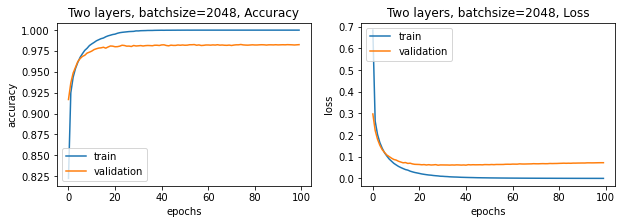

batchsize  2048  elapsed time= 440.1306748390198


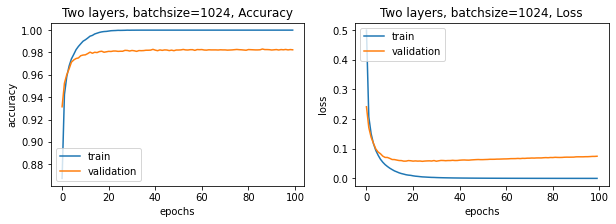

batchsize  1024  elapsed time= 418.8514051437378


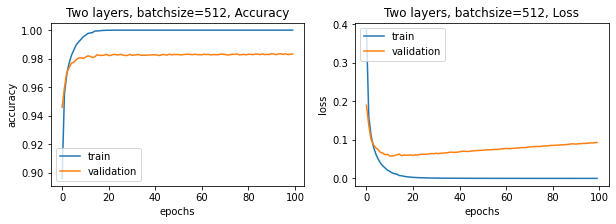

batchsize  512  elapsed time= 393.2055380344391


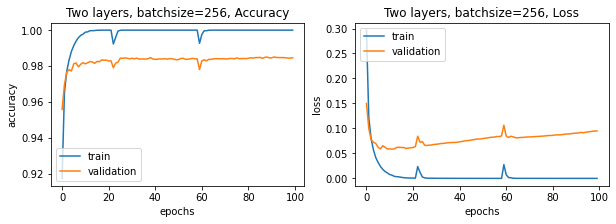

batchsize  256  elapsed time= 374.6704270839691


In [9]:
#
# WARNING: If you're training on a CPU (that is, without a GPU),
# then as batch sizes decrease, running time increases FAST.
# Without a GPU, be careful with batch sizes smaller than 256.
# I'm using big batches here so the notebook runs in less than a
# few days. If you have a fast machine and/or a great GPU, it would
# be instructive to include more sizes, as in the commented definition
# of batch_sizes.
#
import time
history_list = []
time_list = []

#batch_sizes = [2048, 1024, 512, 256, 128, 64, 32, 16, 8]
batch_sizes = [2048, 1024, 512, 256]
for batchsize in batch_sizes:
    model = make_one_hidden_layer_model()
    plot_title = 'Two layers, batchsize='+str(batchsize)
    filename = 'two-layers-batch-'+str(batchsize)
    start_time = time.time()
    history = run_and_report(model, plot_title, filename, batch_size=batchsize, verbosity=0)
    end_time = time.time()
    elapsed_time = end_time-start_time
    history_list.append(history)
    print("batchsize ",batchsize," elapsed time=",elapsed_time)
    time_list.append(elapsed_time)

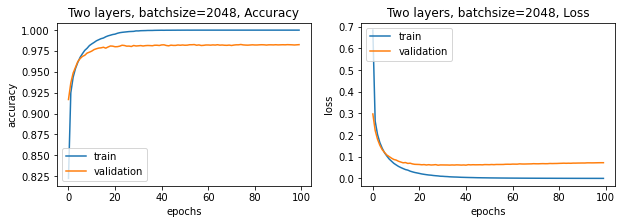

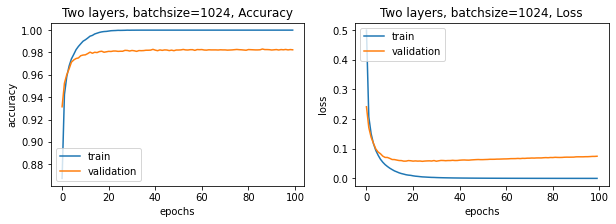

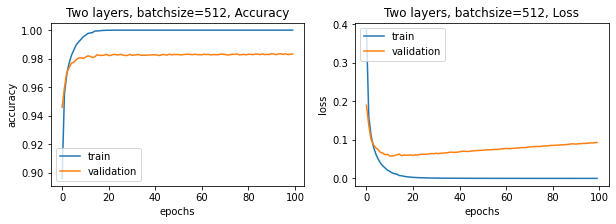

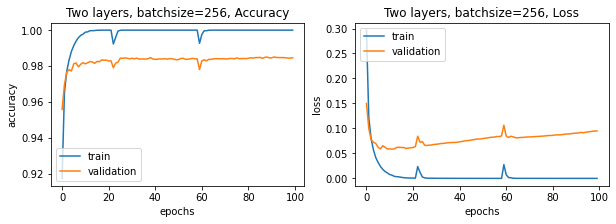

In [10]:
plot_accuracy_and_loss(history_list[0], 'Two layers, batchsize=2048', 'two-layers-batch-2048')
plot_accuracy_and_loss(history_list[1], 'Two layers, batchsize=1024', 'two-layers-batch-1024')
plot_accuracy_and_loss(history_list[2], 'Two layers, batchsize=512', 'two-layers-batch-512')
plot_accuracy_and_loss(history_list[3], 'Two layers, batchsize=256', 'two-layers-batch-256')

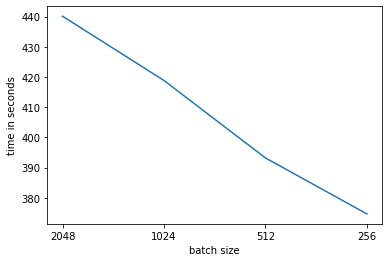

In [11]:
plt.plot(range(len(time_list)), time_list)
plt.xlabel('batch size')
plt.ylabel('time in seconds')
plt.xticks(range(len(time_list)), batch_sizes)
file_helper.save_figure('batch-timing')
plt.show()

In [12]:
# A better size is 256, but that takes a LONG time to run!
comparison_batch_size = 1024

Epoch 1/100
59/59 - 9s - loss: 0.4073 - accuracy: 0.8882 - val_loss: 0.1623 - val_accuracy: 0.9519
Epoch 2/100
59/59 - 7s - loss: 0.1344 - accuracy: 0.9618 - val_loss: 0.1039 - val_accuracy: 0.9684
Epoch 3/100
59/59 - 7s - loss: 0.0826 - accuracy: 0.9758 - val_loss: 0.0802 - val_accuracy: 0.9749
Epoch 4/100
59/59 - 7s - loss: 0.0577 - accuracy: 0.9829 - val_loss: 0.0708 - val_accuracy: 0.9777
Epoch 5/100
59/59 - 7s - loss: 0.0414 - accuracy: 0.9885 - val_loss: 0.0672 - val_accuracy: 0.9793
Epoch 6/100
59/59 - 7s - loss: 0.0278 - accuracy: 0.9923 - val_loss: 0.0633 - val_accuracy: 0.9799
Epoch 7/100
59/59 - 8s - loss: 0.0190 - accuracy: 0.9955 - val_loss: 0.0625 - val_accuracy: 0.9801
Epoch 8/100
59/59 - 7s - loss: 0.0142 - accuracy: 0.9970 - val_loss: 0.0624 - val_accuracy: 0.9798
Epoch 9/100
59/59 - 7s - loss: 0.0107 - accuracy: 0.9976 - val_loss: 0.0652 - val_accuracy: 0.9808
Epoch 10/100
59/59 - 8s - loss: 0.0079 - accuracy: 0.9985 - val_loss: 0.0648 - val_accuracy: 0.9808
Epoch 11/

59/59 - 10s - loss: 7.3569e-06 - accuracy: 1.0000 - val_loss: 0.0960 - val_accuracy: 0.9829
Epoch 81/100
59/59 - 10s - loss: 7.0140e-06 - accuracy: 1.0000 - val_loss: 0.0957 - val_accuracy: 0.9828
Epoch 82/100
59/59 - 10s - loss: 6.7151e-06 - accuracy: 1.0000 - val_loss: 0.0966 - val_accuracy: 0.9826
Epoch 83/100
59/59 - 10s - loss: 6.4139e-06 - accuracy: 1.0000 - val_loss: 0.0964 - val_accuracy: 0.9828
Epoch 84/100
59/59 - 10s - loss: 6.1424e-06 - accuracy: 1.0000 - val_loss: 0.0972 - val_accuracy: 0.9827
Epoch 85/100
59/59 - 10s - loss: 5.8589e-06 - accuracy: 1.0000 - val_loss: 0.0976 - val_accuracy: 0.9831
Epoch 86/100
59/59 - 10s - loss: 5.6409e-06 - accuracy: 1.0000 - val_loss: 0.0977 - val_accuracy: 0.9831
Epoch 87/100
59/59 - 10s - loss: 5.3547e-06 - accuracy: 1.0000 - val_loss: 0.0985 - val_accuracy: 0.9828
Epoch 88/100
59/59 - 9s - loss: 5.0958e-06 - accuracy: 1.0000 - val_loss: 0.0986 - val_accuracy: 0.9826
Epoch 89/100
59/59 - 9s - loss: 4.9146e-06 - accuracy: 1.0000 - val_l

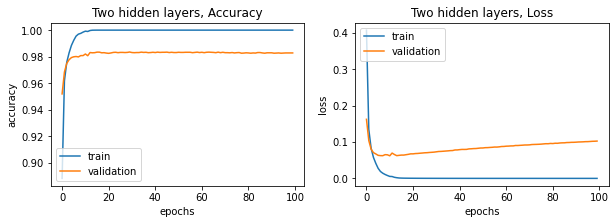

In [13]:
model = make_two_hidden_layers_model()
history_2HLM = run_and_report(model, 'Two hidden layers', 'two-hidden-layers', 
                              batch_size=comparison_batch_size, verbosity=2)

Epoch 1/100
59/59 - 4s - loss: 0.9556 - accuracy: 0.7492 - val_loss: 0.4102 - val_accuracy: 0.8959
Epoch 2/100
59/59 - 1s - loss: 0.3627 - accuracy: 0.9033 - val_loss: 0.3077 - val_accuracy: 0.9161
Epoch 3/100
59/59 - 1s - loss: 0.2913 - accuracy: 0.9211 - val_loss: 0.2657 - val_accuracy: 0.9254
Epoch 4/100
59/59 - 1s - loss: 0.2542 - accuracy: 0.9302 - val_loss: 0.2385 - val_accuracy: 0.9319
Epoch 5/100
59/59 - 1s - loss: 0.2271 - accuracy: 0.9376 - val_loss: 0.2190 - val_accuracy: 0.9386
Epoch 6/100
59/59 - 1s - loss: 0.2065 - accuracy: 0.9431 - val_loss: 0.2011 - val_accuracy: 0.9433
Epoch 7/100
59/59 - 1s - loss: 0.1891 - accuracy: 0.9480 - val_loss: 0.1857 - val_accuracy: 0.9478
Epoch 8/100
59/59 - 1s - loss: 0.1753 - accuracy: 0.9514 - val_loss: 0.1734 - val_accuracy: 0.9511
Epoch 9/100
59/59 - 1s - loss: 0.1630 - accuracy: 0.9546 - val_loss: 0.1643 - val_accuracy: 0.9534
Epoch 10/100
59/59 - 1s - loss: 0.1523 - accuracy: 0.9581 - val_loss: 0.1573 - val_accuracy: 0.9551
Epoch 11/

59/59 - 1s - loss: 0.0097 - accuracy: 0.9989 - val_loss: 0.0901 - val_accuracy: 0.9755
Epoch 84/100
59/59 - 1s - loss: 0.0096 - accuracy: 0.9991 - val_loss: 0.0898 - val_accuracy: 0.9766
Epoch 85/100
59/59 - 1s - loss: 0.0088 - accuracy: 0.9993 - val_loss: 0.0904 - val_accuracy: 0.9775
Epoch 86/100
59/59 - 1s - loss: 0.0086 - accuracy: 0.9992 - val_loss: 0.0907 - val_accuracy: 0.9765
Epoch 87/100
59/59 - 1s - loss: 0.0083 - accuracy: 0.9993 - val_loss: 0.0909 - val_accuracy: 0.9766
Epoch 88/100
59/59 - 1s - loss: 0.0081 - accuracy: 0.9994 - val_loss: 0.0913 - val_accuracy: 0.9769
Epoch 89/100
59/59 - 1s - loss: 0.0078 - accuracy: 0.9995 - val_loss: 0.0923 - val_accuracy: 0.9757
Epoch 90/100
59/59 - 1s - loss: 0.0075 - accuracy: 0.9994 - val_loss: 0.0927 - val_accuracy: 0.9758
Epoch 91/100
59/59 - 1s - loss: 0.0072 - accuracy: 0.9995 - val_loss: 0.0934 - val_accuracy: 0.9766
Epoch 92/100
59/59 - 1s - loss: 0.0070 - accuracy: 0.9995 - val_loss: 0.0924 - val_accuracy: 0.9767
Epoch 93/100


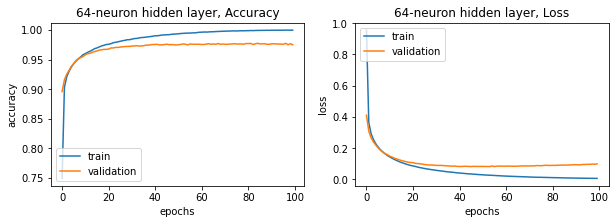

In [14]:
model = make_hidden_layer_n_neurons(64)
history_fc_64 = run_and_report(model, '64-neuron hidden layer', '64-neuron-hidden-layer', 
                               batch_size=comparison_batch_size, verbosity=2)

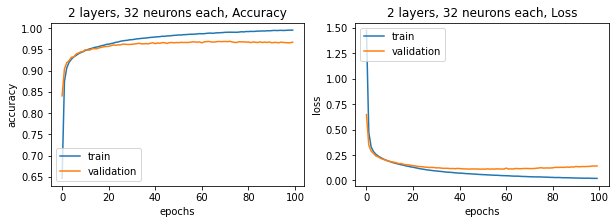

In [15]:
model = make_layers_model([32, 32], [False, False])
history_32_32 = run_and_report(model, '2 layers, 32 neurons each', '32-32-layers', 
                               batch_size=comparison_batch_size, verbosity=0)

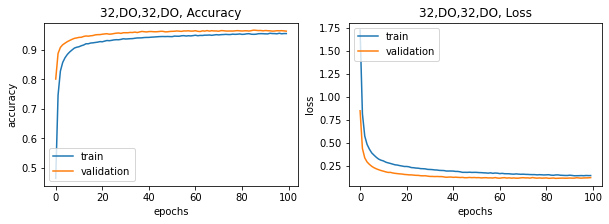

In [16]:
model = make_layers_model([32, 32], [True, True])
history_32_DO_32_DO = run_and_report(model, '32,DO,32,DO', '32-DO-32-DO', 
                               batch_size=comparison_batch_size, verbosity=0)

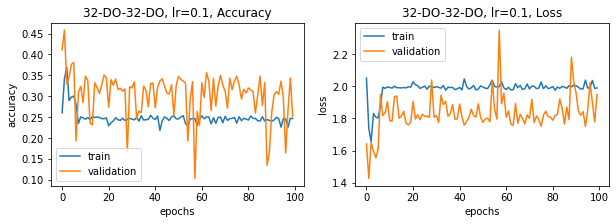

In [17]:
model = make_layers_model([32, 32], [True, True], learning_rate=0.1)
history_32_DO_32_DO_LR_p1 = run_and_report(model, '32-DO-32-DO, lr=0.1', '32-DO-32-DO-LR-p1', 
                               batch_size=comparison_batch_size, verbosity=0)

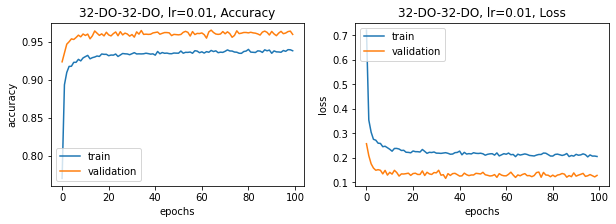

In [18]:
model = make_layers_model([32, 32], [True, True], learning_rate=0.01)
history_32_DO_32_DO_LR_p01 = run_and_report(model, '32-DO-32-DO, lr=0.01', '32-DO-32-DO-LR-p01', 
                               batch_size=comparison_batch_size, verbosity=0)